# 가위바위보 이미지를 통해서 분류기 만들기

실험 목표 : 내가 만든 가위바위보 사진을 학습해, 가위바위보를 분류할수있는 모델을 만들어보자

## 실험 정보

### 데이터
훈련 데이터
- 웹캠을 통해 직접찍은 왼손 가위바위보 사진 300장
- 28X28로 resize, 이후 표준화 /225

테스트 데이터
- 웹캠을 통해 직접찍은 오른손 가위바위보 사진 300장

### 사용한 모델
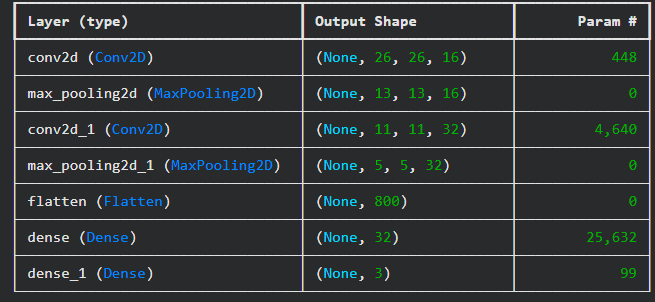

### 실험 결과

test_loss: 3.1421782970428467
test_accuracy: 0.42172524333000183

### 실험 샘플링을 통한 결과 분석

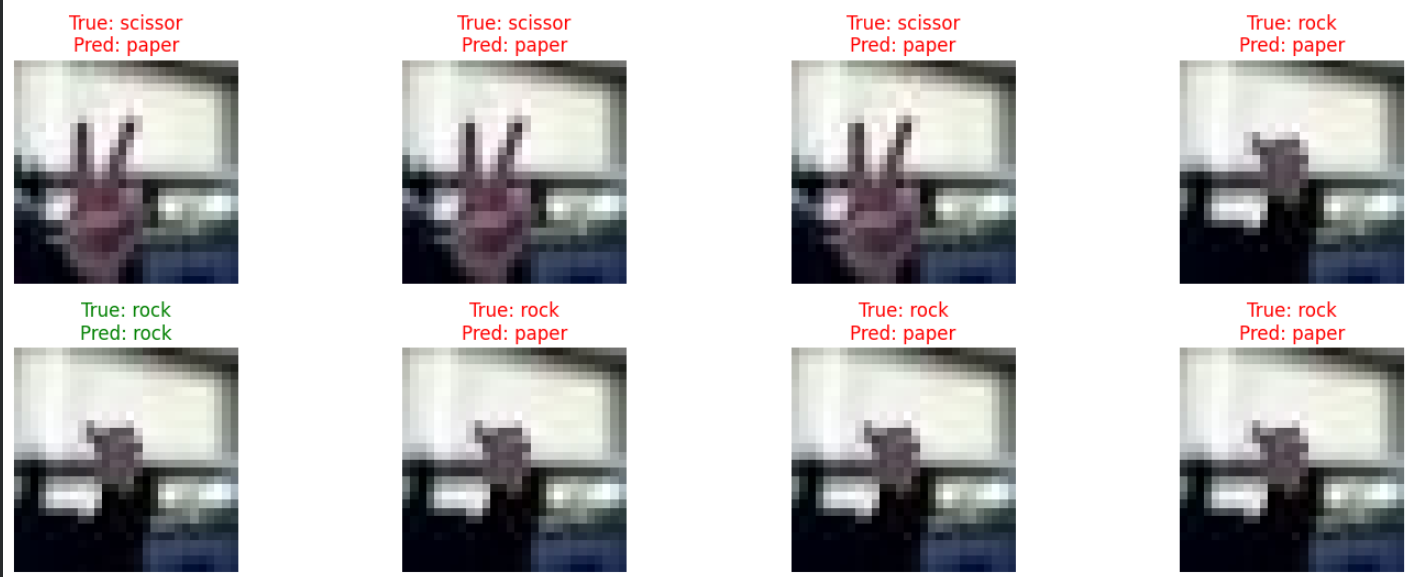

## 회고
결과를 봤을때 대부분을 못맞추는 실험 결과가 나왔다

문제점이라고 생각되는 부분은
사진의 해상도?가 너무 낮아서 파악이 잘 안되는점
훈련 이미지의 종류가 비슷비슷한점, 왼손 오른손으로 바꿨을 뿐인데도 많은 차이가 나는부분이 있다

그리고 데이터를 안섞어도 되는지에 대해서 의문이 있다



In [1]:
# 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 데이터 load 및 압축 해제

import os
import zipfile

# 데이터 루트 경로 - 미리 다운받아둔 데이터로 실험 진행
data_path = '/content/drive/MyDrive/Colab Notebooks/데싸/딥러닝/data'
rps_path = os.path.join(data_path, 'rock_scissor_paper')

# 압축 파일 목록
zip_files = {
    'rock.zip': 'rock',
    'scissor.zip': 'scissor',
    'paper.zip': 'paper'
}

for zip_name, folder_name in zip_files.items():
    zip_path = os.path.join(rps_path, zip_name)           # zip 파일 전체 경로
    extract_dir = os.path.join(rps_path, folder_name)     # 압축 해제될 폴더

    # 폴더 없으면 생성
    os.makedirs(extract_dir, exist_ok=True)

    print(f"🔍 압축 해제 중: {zip_name} → {extract_dir}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

print("✅ 모든 압축 해제 완료!")

🔍 압축 해제 중: rock.zip → /content/drive/MyDrive/Colab Notebooks/데싸/딥러닝/data/rock_scissor_paper/rock
🔍 압축 해제 중: scissor.zip → /content/drive/MyDrive/Colab Notebooks/데싸/딥러닝/data/rock_scissor_paper/scissor
🔍 압축 해제 중: paper.zip → /content/drive/MyDrive/Colab Notebooks/데싸/딥러닝/data/rock_scissor_paper/paper
✅ 모든 압축 해제 완료!


# 오류 리포트
- 아래와 같은 오류가 난다
AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

from PIL import Image 의 버전 변화로 인한 오류

- 오류나는 버전

```python
new_img=old_img.resize(target_size,Image.ANTIALIAS)
```
- 오류 안나게 바꾼 버전
```python
new_img = old_img.resize(target_size, Image.Resampling.LANCZOS)
```

참고 : 그래서 이게 뭐지?
이미지를 리샘플링할때 어떤 보간 방법을 사용할지를 결정한다

In [10]:
# 이미지 resize 방식 사용

from PIL import Image
import glob

def resize_images(img_path):
  images=glob.glob(img_path + "/*.jpg")

  print(len(images), " images to be resized.")

  # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
  target_size=(28,28)
  for img in images:
    old_img=Image.open(img)
    # new_img=old_img.resize(target_size,Image.ANTIALIAS)
    new_img = old_img.resize(target_size, Image.Resampling.LANCZOS)
    new_img.save(img, "JPEG")

  print(len(images), " images resized.")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
rock_img_path = os.path.join(rps_path, 'rock')
resize_images(rock_img_path)

print("바위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
바위 이미지 resize 완료!


In [9]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
scissor_img_path = os.path.join(rps_path, 'scissor')
paper_img_path = os.path.join(rps_path, 'paper')

resize_images(scissor_img_path)
resize_images(paper_img_path)

107  images to be resized.
107  images resized.
105  images to be resized.
105  images resized.


# 오류 리포트

우리가 사진을 딱 300개를 안찍어서 이 부분에서 오류가 난다

- 기존방식 - imgs[idx,:,:,:]=img   
처음부터 데이터 행렬의 크기를 고정하고 거기에 추가하는 방식


- 바꾼 방식 - append   
유동적으로 한쪽의 차원에 새롭게 데이터를 넣는방식

In [18]:
# 이미지 - 라벨 (하나하나를 맞춰주는 코드를 작성한다)

import numpy as np

def load_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    imgs = []
    labels = []

    # 1. scissor
    for file in glob.iglob(os.path.join(img_path, 'scissor', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(0)   # 가위 : 0

    # 2. rock
    for file in glob.iglob(os.path.join(img_path, 'rock', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(1)   # 바위 : 1

    # 3. paper
    for file in glob.iglob(os.path.join(img_path, 'paper', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(2)   # 보 : 2

    # 리스트 → 넘파이 배열로 변환
    imgs = np.stack(imgs, axis=0)              # (N, H, W, C)
    labels = np.array(labels, dtype=np.int32)  # (N,)

    print("학습데이터(x_train)의 이미지 개수는", len(labels), "입니다.")
    return imgs, labels

# 사용 예시
x_train, y_train = load_data(rps_path)
x_train_norm = x_train / 255.0

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

학습데이터(x_train)의 이미지 개수는 312 입니다.
x_train shape: (312, 28, 28, 3)
y_train shape: (312,)


In [12]:
# import numpy as np

# def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
#     # 가위 : 0, 바위 : 1, 보 : 2
#     img_size=28
#     color=3
#     #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
#     imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
#     labels=np.zeros(number_of_data,dtype=np.int32)

#     idx=0
#     for file in glob.iglob(img_path+'/scissor/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=0   # 가위 : 0
#         idx=idx+1

#     for file in glob.iglob(img_path+'/rock/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=1   # 바위 : 1
#         idx=idx+1

#     for file in glob.iglob(img_path+'/paper/*.jpg'):
#         img = np.array(Image.open(file),dtype=np.int32)
#         imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
#         labels[idx]=2   # 보 : 2
#         idx=idx+1

#     print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
#     return imgs, labels

# (x_train, y_train)=load_data(rps_path)
# x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

# print("x_train shape: {}".format(x_train.shape))
# print("y_train shape: {}".format(y_train.shape))

IndexError: index 300 is out of bounds for axis 0 with size 300

라벨:  1


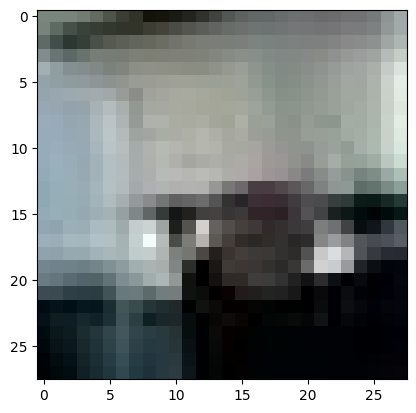

In [17]:
# 이미지 확인 - 화질이 생각보다 상당히 안좋은것을 확인할수있다

import matplotlib.pyplot as plt

plt.imshow(x_train[123])
print('라벨: ', y_train[123])

In [19]:
# 모델 만들기

import tensorflow as tf
from tensorflow import keras
import numpy as np

# 아래의 하이퍼파라미터는 예시입니다. 높은 인식률을 얻기 위해 하이퍼파라미터를 수정해 보세요.
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,819 (120.39 KB)

 Trainable params: 30,819 (120.39 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train, y_train, epochs=n_train_epoch)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3512 - loss: 28.5845
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6914 - loss: 2.4173
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8608 - loss: 0.7109
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9480 - loss: 0.2263
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9638 - loss: 0.1067
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9700 - loss: 0.0828
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9792 - loss: 0.0556
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9776 - loss: 0.0515
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9788 - loss: 0.0673
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9914 - loss: 0.0420


In [21]:
# 테스트용 데이터 불러오기

# 압축 파일 목록
zip_files = {
    'rock_test.zip': 'rock_test',
    'scissor_test.zip': 'scissor_test',
    'paper_test.zip': 'paper_test'
}

for zip_name, folder_name in zip_files.items():
    zip_path = os.path.join(rps_path, zip_name)           # zip 파일 전체 경로
    extract_dir = os.path.join(rps_path, folder_name)     # 압축 해제될 폴더

    # 폴더 없으면 생성
    os.makedirs(extract_dir, exist_ok=True)

    print(f"🔍 압축 해제 중: {zip_name} → {extract_dir}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

print("✅ 모든 압축 해제 완료!")

🔍 압축 해제 중: rock_test.zip → /content/drive/MyDrive/Colab Notebooks/데싸/딥러닝/data/rock_scissor_paper/rock_test
🔍 압축 해제 중: scissor_test.zip → /content/drive/MyDrive/Colab Notebooks/데싸/딥러닝/data/rock_scissor_paper/scissor_test
🔍 압축 해제 중: paper_test.zip → /content/drive/MyDrive/Colab Notebooks/데싸/딥러닝/data/rock_scissor_paper/paper_test
✅ 모든 압축 해제 완료!


In [22]:
# 이미지 전처리
rock_test_img_path = os.path.join(rps_path, 'rock_test')
resize_images(rock_test_img_path)
scissor_test_img_path = os.path.join(rps_path, 'scissor_test')
resize_images(scissor_test_img_path)
paper_test_img_path = os.path.join(rps_path, 'paper_test')
resize_images(paper_test_img_path)

102  images to be resized.
102  images resized.
107  images to be resized.
107  images resized.
104  images to be resized.
104  images resized.


In [24]:
# 이미지 - 라벨 (하나하나를 맞춰주는 코드를 작성한다)

import numpy as np

def load_test_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    imgs = []
    labels = []

    # 1. scissor
    for file in glob.iglob(os.path.join(img_path, 'scissor_test', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(0)   # 가위 : 0

    # 2. rock
    for file in glob.iglob(os.path.join(img_path, 'rock_test', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(1)   # 바위 : 1

    # 3. paper
    for file in glob.iglob(os.path.join(img_path, 'paper_test', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(2)   # 보 : 2

    # 리스트 → 넘파이 배열로 변환
    imgs = np.stack(imgs, axis=0)              # (N, H, W, C)
    labels = np.array(labels, dtype=np.int32)  # (N,)

    print("학습데이터(x_test)의 이미지 개수는", len(labels), "입니다.")
    return imgs, labels

# 사용 예시
x_test, y_test = load_test_data(rps_path)
x_test_norm = x_test / 255.0

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

학습데이터(x_test)의 이미지 개수는 313 입니다.
x_test shape: (313, 28, 28, 3)
y_test shape: (313,)


In [25]:
# 테스트

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - 42ms/step - accuracy: 0.4217 - loss: 3.1422
test_loss: 3.1421782970428467 
test_accuracy: 0.42172524333000183


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


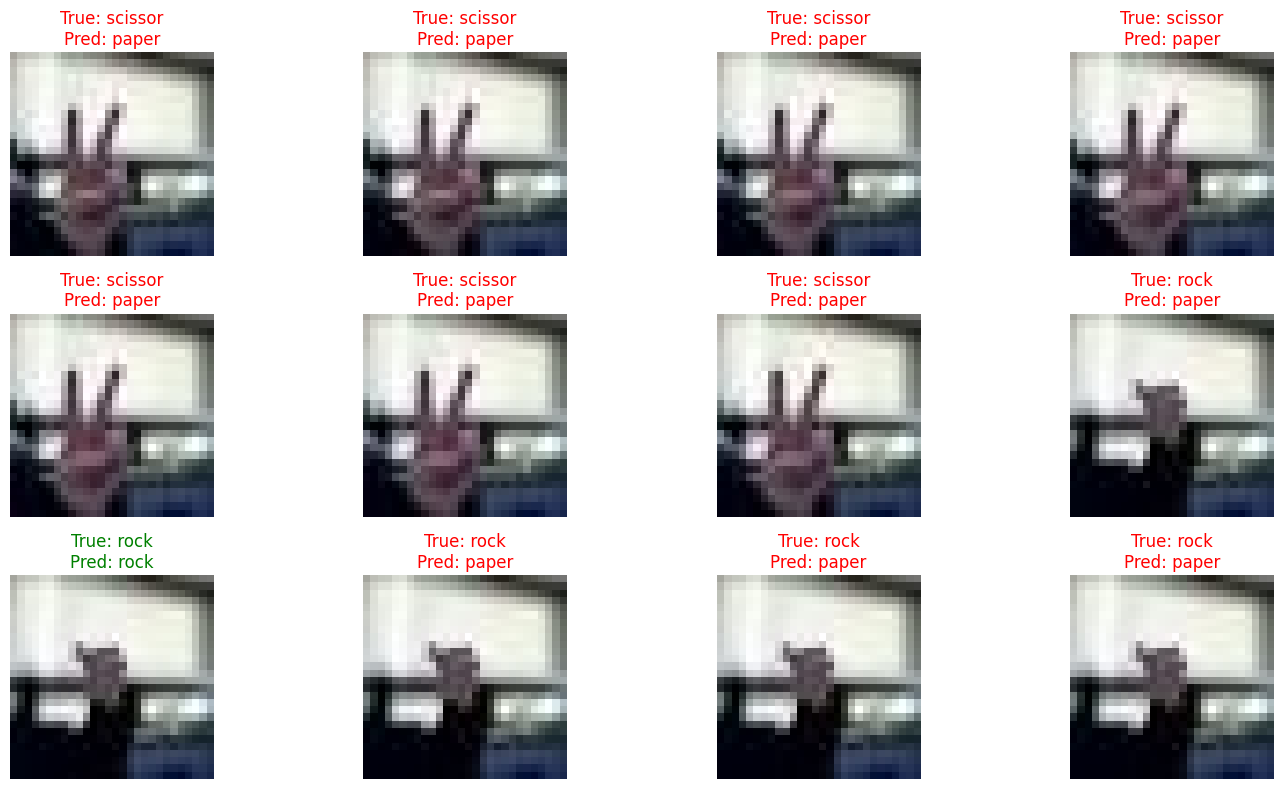

In [32]:
# 시각화

import matplotlib.pyplot as plt
import numpy as np

# 클래스 이름 매핑
class_names = ['scissor', 'rock', 'paper']   # 0, 1, 2

# 모델 예측
pred = model.predict(x_test)          # (N, 3)
pred_label = np.argmax(pred, axis=1)  # 예측 라벨

# 원하는 만큼 출력
start_idx = 100
num_images = 12
plt.figure(figsize=(15, 8))

for i in range(num_images):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_test[start_idx+i])
    plt.axis('off')

    true_name = class_names[y_test[start_idx+i]]
    pred_name = class_names[pred_label[start_idx+i]]

    # 정답 / 예측 출력
    color = 'green' if y_test[start_idx+i] == pred_label[start_idx+i] else 'red'
    plt.title(f"True: {true_name}\nPred: {pred_name}", color=color)

plt.tight_layout()
plt.show()